# Setup & imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Optional modeling libs

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Notebook plotting settings

In [3]:
%matplotlib inline
plt.style.use('default')
sns.set_context('talk')

# Helper Function

In [10]:
def try_load_data(data_dir='data'):
    """
    Try to find a dataset file in data/ and load it.
    Accepts: online_retail_II.xlsx, online_retail.csv, OnlineRetail.csv, etc.
    Returns pandas DataFrame.
    """
    with open(rf'{data_dir}\online_retail_II.csv') as f:
        return pd.read_csv(f)

In [22]:
def save_fig(fig, fname):
    """Save figure into images/ folder (create if missing)."""
    os.makedirs('images', exist_ok=True)
    path = os.path.join('images', fname)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    print("Saved:", path)

# Loading Data

In [11]:
df = try_load_data()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,01-12-2009 07:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,01-12-2009 07:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,01-12-2009 07:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,01-12-2009 07:45,1.25,13085.0,United Kingdom


## Describing Data

In [12]:
print("Rows:", df.shape[0], "Columns:", df.shape[1])
df.info()
df.describe(include='all').T.head(20)

Rows: 525461 Columns: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Invoice,525461,28816,537434,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,525461,4632,85123A,3516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,522533,4681,WHITE HANGING HEART T-LIGHT HOLDER,3549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,525461.0,NaN,NaN,NaN,10.337667,107.42411,-9600.0,1.0,3.0,10.0,19152.0
InvoiceDate,525461,25296,06-12-2010 16:57,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,525461.0,NaN,NaN,NaN,4.688834,146.126914,-53594.36,1.25,2.1,4.21,25111.09
Customer ID,417534.0,NaN,NaN,NaN,15360.645478,1680.811316,12346.0,13983.0,15311.0,16799.0,18287.0
Country,525461,40,United Kingdom,485852,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Standarizing Data

In [17]:
df.columns = [c.strip() for c in df.columns]
expected_cols = ['Invoice', 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
# Try to map common variants
col_map = {}
for c in df.columns:
    lc = c.lower()
    if 'invoice' in lc and 'date' not in lc:
        col_map[c] = 'InvoiceNo'
    elif 'stock' in lc:
        col_map[c] = 'StockCode'
    elif 'description' in lc:
        col_map[c] = 'Description'
    elif 'quantity' in lc:
        col_map[c] = 'Quantity'
    elif 'date' in lc:
        col_map[c] = 'InvoiceDate'
    elif 'price' in lc:
        col_map[c] = 'UnitPrice'
    elif 'customer' in lc:
        col_map[c] = 'CustomerID'
    elif 'country' in lc:
        col_map[c] = 'Country'
    elif 'invoice' in lc and 'date' in lc:
        col_map[c] = 'InvoiceDate'
# apply mapping
df = df.rename(columns=col_map)
print("Columns after rename:", df.columns.tolist())

Columns after rename: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


# Data Cleaning

In [18]:
"""
Cleaning plan:
- Parse InvoiceDate to datetime
- Remove rows with missing CustomerID (depending on analysis needs)
- Remove cancellations (InvoiceNo starting with 'C')
- Remove quantities <= 0 or unit price <= 0 (likely returns or bad data)
- Create TotalPrice = Quantity * UnitPrice
- Drop duplicates
- Fill or clean Description text
"""
# Convert InvoiceDate
if 'InvoiceDate' in df.columns:
    try:
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    except:
        # try alternative formats
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
# Remove duplicates
df.drop_duplicates(inplace=True)
# Remove cancellation rows (InvoiceNo starting with 'C' or containing 'C')
if 'InvoiceNo' in df.columns:
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C', na=False)]
# Ensure numeric types
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
# Remove non-positive quantities or prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
# Clean Description
if 'Description' in df.columns:
    df['Description'] = df['Description'].astype(str).str.strip().str.lower()
# Drop rows with all NaNs in key fields
df = df.dropna(subset=['InvoiceDate', 'Quantity', 'UnitPrice', 'TotalPrice'])
print("After cleaning rows:", df.shape[0])

After cleaning rows: 209304


# Statistics

In [19]:
display(df[['Quantity','UnitPrice','TotalPrice']].describe().T)
print("Unique customers:", df['CustomerID'].nunique() if 'CustomerID' in df.columns else 'no customer column')
print("Unique products:", df['StockCode'].nunique() if 'StockCode' in df.columns else 'no stockcode')

,count,mean,std,min,25%,50%,75%,max
Quantity,209304.0,11.266392,67.591844,1.000,1.00,3.0,10.00,9360.00
UnitPrice,209304.0,4.140714,47.315464,0.001,1.25,2.1,4.21,13541.33
TotalPrice,209304.0,20.512831,88.365890,0.001,4.20,10.2,17.70,15818.40


Unique customers: 2961
Unique products: 4086


## Top Companies by Revenue

Saved: images\top_countries_revenue.png


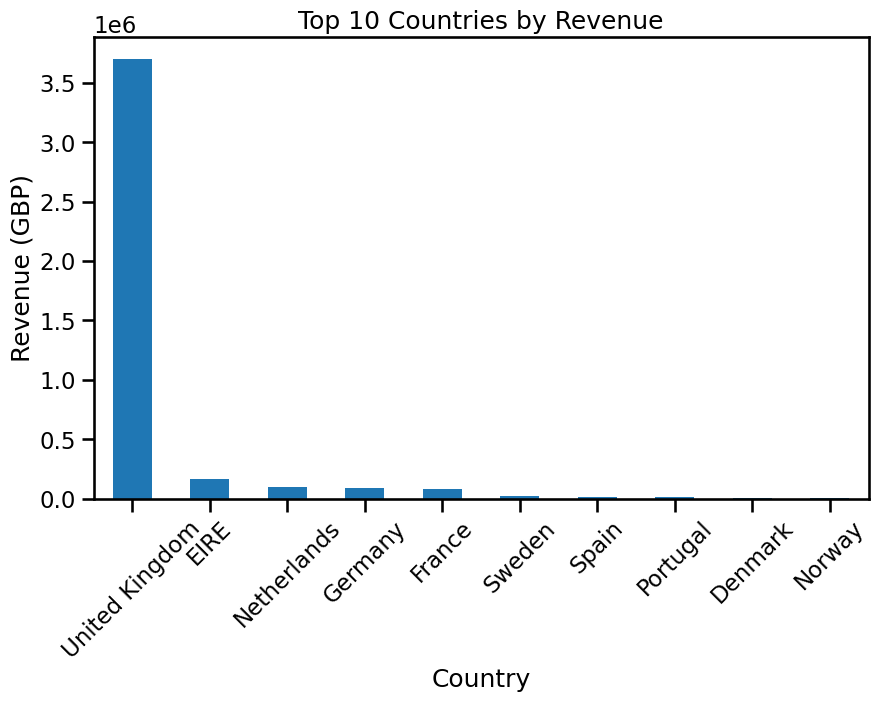

In [23]:
if 'Country' in df.columns:
    country_rev = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(10,6))
    country_rev.plot(kind='bar', ax=ax)
    ax.set_title('Top 10 Countries by Revenue')
    ax.set_ylabel('Revenue (GBP)')
    ax.set_xlabel('Country')
    plt.xticks(rotation=45)
    save_fig(fig, 'top_countries_revenue.png')
    plt.show()

## Top Product by revenue

Saved: images\top_products_revenue.png


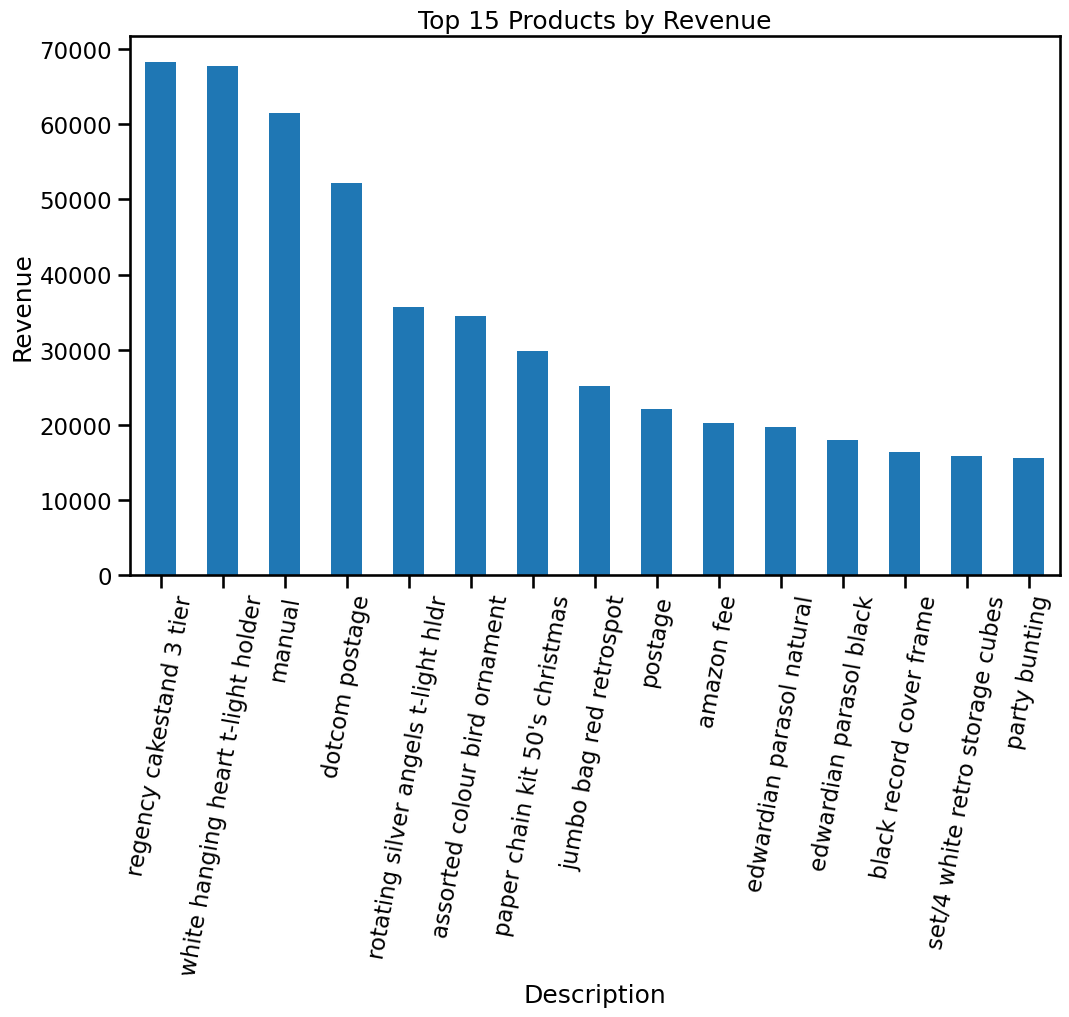

In [24]:
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(15)
fig, ax = plt.subplots(figsize=(12,7))
top_products.plot(kind='bar')
ax.set_title('Top 15 Products by Revenue')
ax.set_ylabel('Revenue')
plt.xticks(rotation=80)
save_fig(fig, 'top_products_revenue.png')
plt.show()

## Monthly sales time-series

Saved: images\monthly_revenue.png


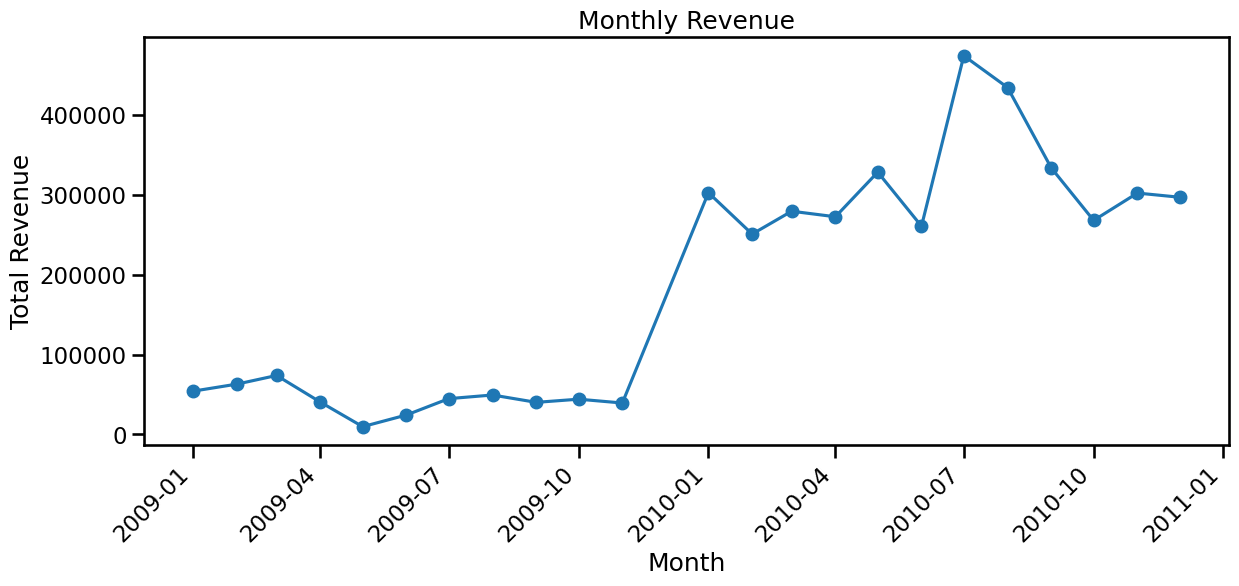

In [25]:
df.set_index('InvoiceDate', inplace=False)
df_ts = df.copy()
df_ts['InvoiceMonth'] = df_ts['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
monthly_sales = df_ts.groupby('InvoiceMonth')['TotalPrice'].sum().sort_index()
fig, ax = plt.subplots(figsize=(14,6))
monthly_sales.plot(ax=ax, marker='o')
ax.set_title("Monthly Revenue")
ax.set_ylabel("Total Revenue")
ax.set_xlabel("Month")
plt.xticks(rotation=45)
save_fig(fig, 'monthly_revenue.png')
plt.show()

## Seasonality by month of year

Saved: images\seasonality_by_month.png


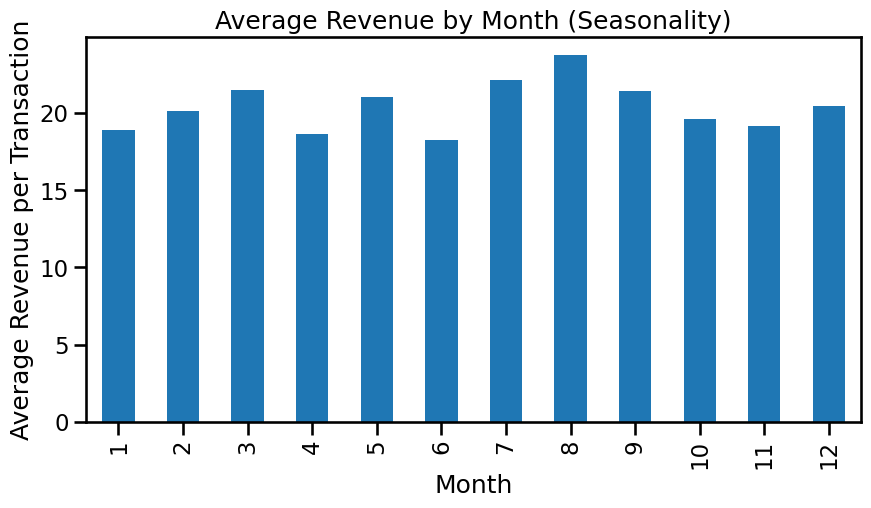

In [26]:
df_ts['month'] = df_ts['InvoiceDate'].dt.month
monthly_avg = df_ts.groupby('month')['TotalPrice'].mean()
fig, ax = plt.subplots(figsize=(10,5))
monthly_avg.plot(kind='bar', ax=ax)
ax.set_title('Average Revenue by Month (Seasonality)')
ax.set_xlabel('Month')
ax.set_ylabel('Average Revenue per Transaction')
save_fig(fig,'seasonality_by_month.png')
plt.show()

## Correlation heatmap between numeric features

Saved: images\numeric_correlation.png


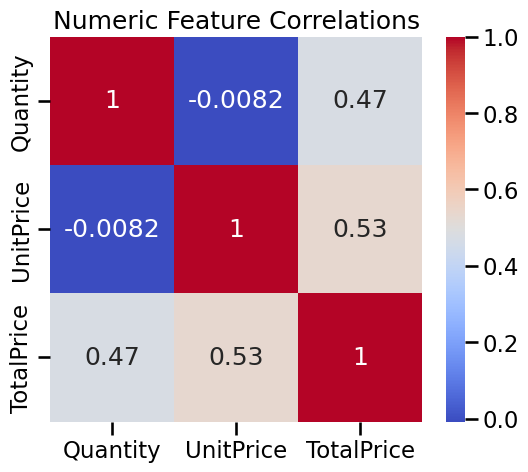

In [27]:
num_cols = ['Quantity','UnitPrice','TotalPrice']
corr = df[num_cols].corr()
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Numeric Feature Correlations')
save_fig(fig,'numeric_correlation.png')
plt.show()

## Distribution plots (Quantity & UnitPrice)

In [41]:
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[(series >= Q1 - 1.5*IQR) & (series <= Q3 + 1.5*IQR)]


In [42]:
df_viz = df.copy()
df_viz = df_viz[df_viz['Quantity'].between(
    df_viz['Quantity'].quantile(0.01),
    df_viz['Quantity'].quantile(0.99)
)]

df_viz = df_viz[df_viz['UnitPrice'].between(
    df_viz['UnitPrice'].quantile(0.01),
    df_viz['UnitPrice'].quantile(0.99)
)]

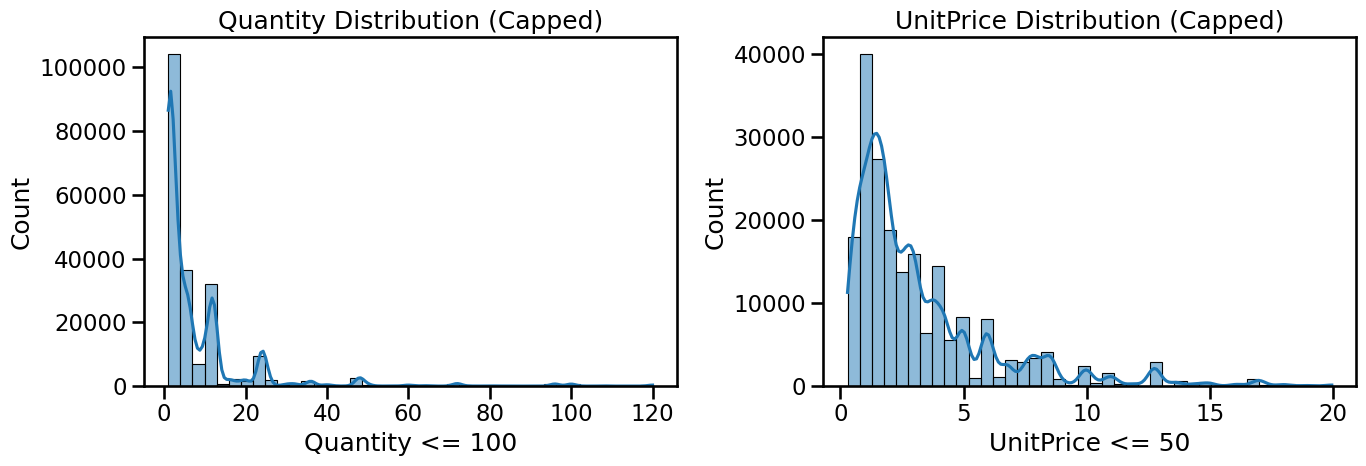

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df_viz['Quantity'], bins=40, kde=True, ax=axes[0])
axes[0].set_title("Quantity Distribution (Capped)")
axes[0].set_xlabel("Quantity <= 100")

sns.histplot(df_viz['UnitPrice'], bins=40, kde=True, ax=axes[1])
axes[1].set_title("UnitPrice Distribution (Capped)")
axes[1].set_xlabel("UnitPrice <= 50")

plt.tight_layout()
plt.show()

## Customer aggregation: revenue per customer & basic RFM features

In [29]:
if 'CustomerID' in df.columns:
    cust = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }).reset_index()
    cust.columns = ['CustomerID','Recency','Frequency','Monetary']
    cust.describe().T
    # Show top 10 customers by monetary
    display(cust.sort_values('Monetary', ascending=False).head(10))

,CustomerID,Recency,Frequency,Monetary
2878,18102.0,7,39,181661.55
880,14156.0,2,30,99966.56
1136,14646.0,8,30,91077.49
1349,15061.0,0,50,61051.06
1278,14911.0,0,77,58573.48
638,13694.0,3,42,54823.98
1735,15838.0,1,10,37242.80
2585,17511.0,6,17,33606.24
1835,16029.0,7,29,28542.50
2189,16754.0,7,13,28230.77


## Customer segmentation with KMeans (RFM)

In [36]:
if 'CustomerID' in df.columns:
    rfm = cust[['Recency','Frequency','Monetary']].fillna(0)
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm)
    # choose 4 clusters as a reasonable starter
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    cust['Cluster'] = labels
    # Visualize cluster centers in original scale
    centers = scaler.inverse_transform(kmeans.cluster_centers_)
    centers_df = pd.DataFrame(centers, columns=['Recency','Frequency','Monetary'])
    print("Cluster centers (approx):")
    display(centers_df)
    # Show cluster sizes
    display(cust['Cluster'].value_counts())

Cluster centers (approx):


,Recency,Frequency,Monetary
0,21.505882,15.376471,9280.828600
1,82.318687,2.566162,952.152350
2,26.555556,51.888889,67829.106667
3,335.947012,1.302142,450.543258


Cluster
1    1980
3     887
0      85
2       9
Name: count, dtype: int64

## Analyze clusters (interpretation)

,Recency,Frequency,Monetary,NumCustomers
Cluster,,,,
2,26.555556,51.888889,67829.106667,9
0,21.505882,15.376471,9280.828600,85
1,82.318687,2.566162,952.152350,1980
3,335.947012,1.302142,450.543258,887


Saved: images\clusters_freq_monetary.png


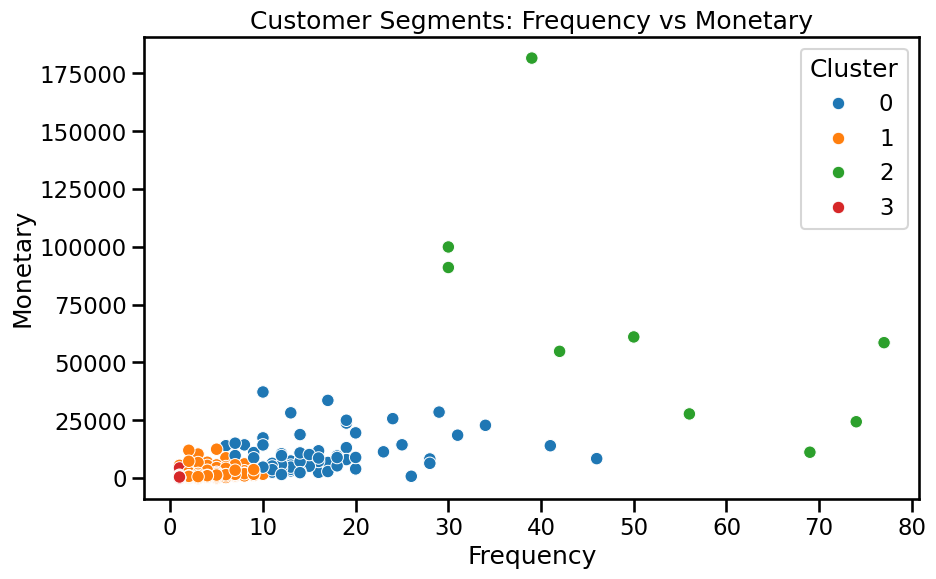

In [ ]:
if 'Cluster' in cust.columns:
    cluster_summary = cust.groupby('Cluster').agg({
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary':'mean',
        'CustomerID':'count'
    }).rename(columns={'CustomerID':'NumCustomers'}).sort_values('Monetary', ascending=False)
    display(cluster_summary)
    # Plot cluster Monetary vs Frequency
    fig, ax = plt.subplots(figsize=(10,6))
    sns.scatterplot(data=cust, x='Frequency', y='Monetary', hue='Cluster', palette='tab10', ax=ax)
    ax.set_title('Customer Segments: Frequency vs Monetary')
    save_fig(fig,'clusters_freq_monetary.png')
    plt.show()


## Simple forecasting: linear regression on monthly totals

Saved: images\forecast_linear.png


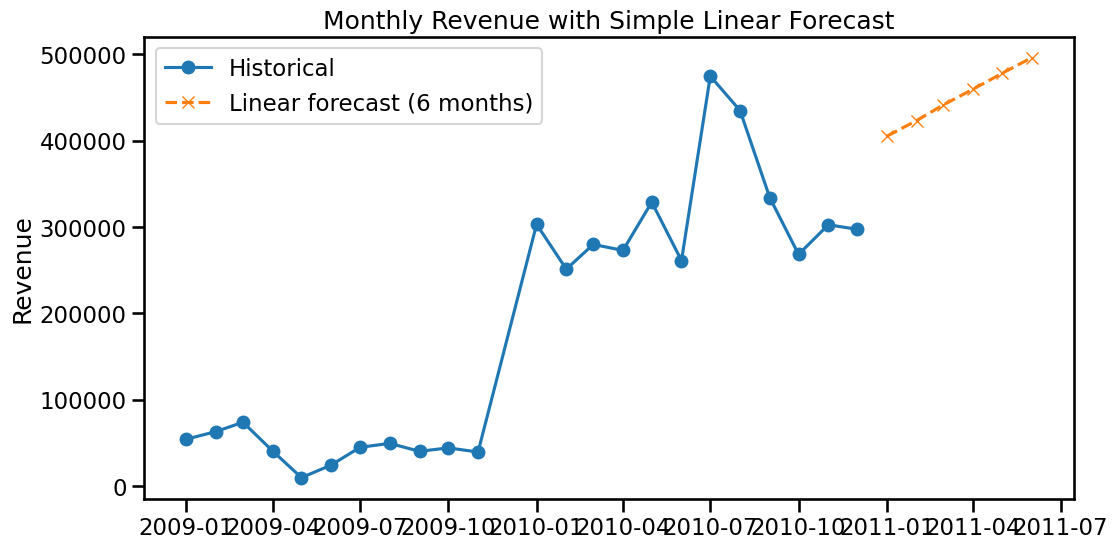

In [33]:
# Prepare data
monthly = monthly_sales.reset_index()
monthly['month_num'] = np.arange(len(monthly))
X = monthly[['month_num']]
y = monthly['TotalPrice']
model = LinearRegression()
model.fit(X, y)
# Predict next 6 months
future_idx = np.arange(len(monthly), len(monthly)+6).reshape(-1,1)
preds = model.predict(future_idx)
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(monthly['InvoiceMonth'], monthly['TotalPrice'], marker='o', label='Historical')
future_months = pd.date_range(start=monthly['InvoiceMonth'].iloc[-1] + pd.offsets.MonthBegin(1), periods=6, freq='MS')
ax.plot(future_months, preds, marker='x', linestyle='--', label='Linear forecast (6 months)')
ax.set_title('Monthly Revenue with Simple Linear Forecast')
ax.set_ylabel('Revenue')
ax.legend()
save_fig(fig,'forecast_linear.png')
plt.show()

INSIGHTS (example statements — write these as markdown cells in notebook):

- Top-selling products: The top 15 products contribute a large portion of total revenue. This suggests focusing promotions and inventory management on these SKUs.
- Seasonality: Revenue peaks are visible in Nov–Dec, suggesting strong holiday effect. Prepare inventory and marketing campaigns for Q4.
- Customer segments: RFM clustering reveals a small number of high-monetary, high-frequency customers — prioritize retention strategies (loyalty programs) for these segments.
- Revenue drivers: High unit price items and frequency of repeat customers drive most revenue. Consider bundling and cross-sell to increase basket size.

RECOMMENDATIONS:
1. Create targeted retention campaigns (email, discounts) for high-value clusters.
2. Manage inventory to ensure top 20 SKUs are always in stock.
3. Prepare seasonal promotions for Oct-Dec.
4. Build dashboards to monitor monthly revenue and customer churn.